### 1.Setup & Data Loading

In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import sys
sys.path.append(os.path.abspath('..'))
import config 

# --- CONFIGURATION (Adjust these paths for your local machine) ---
DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
# core
INPUT_FOLDER = os.path.join(DATA_BASE_PATH, "Core_17")
CK_CHANNEL_IDX = 6

# Helper to load specific slices
def get_slice_number(filename):
    match = re.search(r"TMA_(\d+)_", os.path.basename(filename))
    return int(match.group(1)) if match else 0

# Load file list
raw_files = glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif"))
file_list = sorted(raw_files, key=get_slice_number)

print(f"Found {len(file_list)} slices.")

# --- VISUALIZATION HELPER ---
def show_overlay(fixed, moving, title="Overlay"):
    """
    Simple overlay viewer for notebook.
    Red = Fixed, Green = Moving
    """
    f_arr = sitk.GetArrayFromImage(fixed)
    m_arr = sitk.GetArrayFromImage(moving)
    
    # Simple Normalize 
    f_norm = f_arr / (f_arr.max() + 1e-6)
    m_norm = m_arr / (m_arr.max() + 1e-6)
    
    rgb = np.dstack((f_norm, m_norm, np.zeros_like(f_norm)))
    
    plt.figure(figsize=(8,8))
    plt.imshow(np.clip(rgb, 0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()

# LOAD TWO PROBLEMATIC SLICES (e.g., Z4 and Z5 from your image)
# Adjust indices [4] and [5] if your file sorting is different
fixed_img_full = sitk.ReadImage(file_list[11]) 
moving_img_full = sitk.ReadImage(file_list[12])

print(f"Loaded Slice {get_slice_number(file_list[11])} (Fixed) and Slice {get_slice_number(file_list[12])} (Moving)")

Found 20 slices.
Loaded Slice 12 (Fixed) and Slice 13 (Moving)


### 2.original intensity based method

Starting Baseline Registration...
Final Metric: -0.01020119857801933
Parameters (Rad, X, Y): (0.6841328111307392, -1.457631308868525, -1.409092285743701)


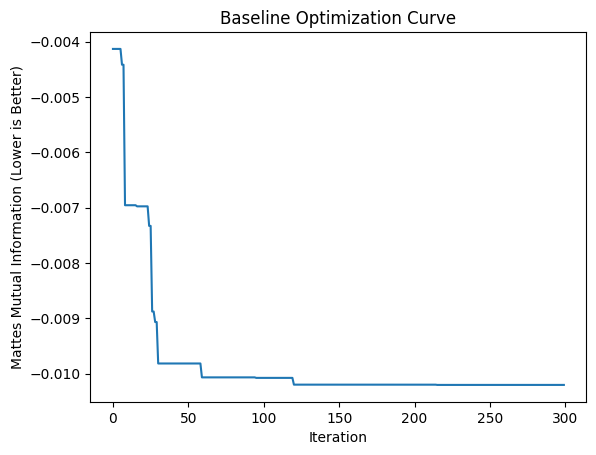

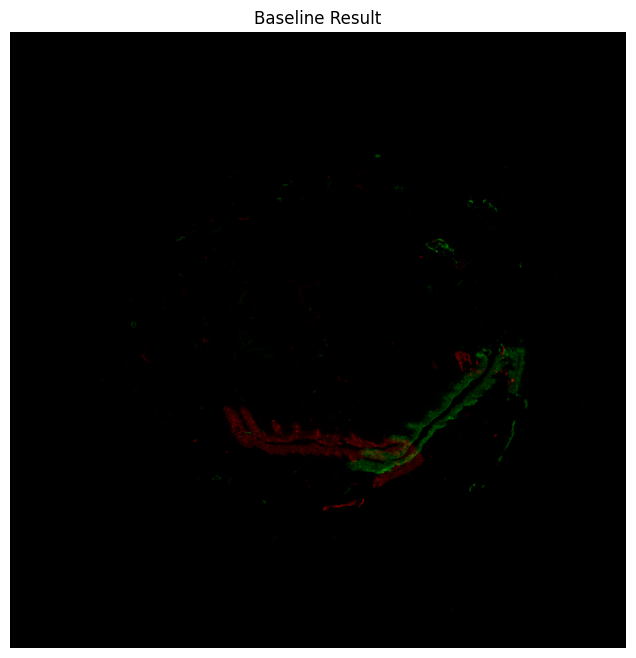

In [3]:
def register_baseline_logic(fixed_full_image, moving_full_image):
    # Extract CK Channel
    fixed_ck = sitk.Cast(fixed_full_image[:, :, CK_CHANNEL_IDX], sitk.sitkFloat32)
    moving_ck = sitk.Cast(moving_full_image[:, :, CK_CHANNEL_IDX], sitk.sitkFloat32)
    
    # 1. GEOMETRY CENTER INITIALIZATION
    initial_tx = sitk.CenteredTransformInitializer(
        fixed_ck, moving_ck, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.GEOMETRY 
    )
    
    # 2. YOUR EXACT SETTINGS
    reg = sitk.ImageRegistrationMethod()
    reg.SetShrinkFactorsPerLevel([16]) 
    reg.SetSmoothingSigmasPerLevel([2]) 
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    # Metric
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.20)
    
    # Optimizer: OnePlusOne (Your current "GA")
    reg.SetOptimizerAsOnePlusOneEvolutionary(
        numberOfIterations=300, 
        epsilon=1e-6, 
        initialRadius=1.5,  # <--- CRITICAL PARAMETER
        growthFactor=1.1, 
        shrinkFactor=0.9
    )
    
    reg.SetInitialTransform(initial_tx)
    
    # Observer to plot the metric value LIVE
    metric_values = []
    reg.AddCommand(sitk.sitkIterationEvent, lambda: metric_values.append(reg.GetMetricValue()))
    
    print("Starting Baseline Registration...")
    try:
        final_tx = reg.Execute(fixed_ck, moving_ck)
        
        # --- FIX IS HERE ---
        # Get the value from the 'reg' object, NOT the 'final_tx' object
        final_metric_value = reg.GetMetricValue() 
        print(f"Final Metric: {final_metric_value}")
        print(f"Parameters (Rad, X, Y): {final_tx.GetParameters()}")
        
        # Plot the Optimization Curve
        plt.plot(metric_values)
        plt.title("Baseline Optimization Curve")
        plt.xlabel("Iteration")
        plt.ylabel("Mattes Mutual Information (Lower is Better)")
        plt.show()
        
        return final_tx
        
    except Exception as e:
        print(f"Registration Failed: {e}")
        return initial_tx
# RUN IT
final_transform = register_baseline_logic(fixed_img_full, moving_img_full)

# RESAMPLE AND SHOW RESULT
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_img_full[:,:,CK_CHANNEL_IDX])
resampler.SetTransform(final_transform)
resampler.SetInterpolator(sitk.sitkLinear)
moving_resampled_ck = resampler.Execute(sitk.Cast(moving_img_full[:,:,CK_CHANNEL_IDX], sitk.sitkFloat32))

show_overlay(
    sitk.Cast(fixed_img_full[:,:,CK_CHANNEL_IDX], sitk.sitkFloat32), 
    moving_resampled_ck, 
    title="Baseline Result"
)

### Cell 3: Gradient Optimizers on Mean Squares

Optimizer                      | Final Metric | Stop Condition
---------------------------------------------------------------------------
RegularStepGradientDescent     | 775.7284       | RegularStepGradientDescentOpti...
GradientDescentLineSearch      | 511.6234       | GradientDescentLineSearchOptim...
LBFGSB                         | 508.5669       | LBFGSBOptimizerv4: Function to...


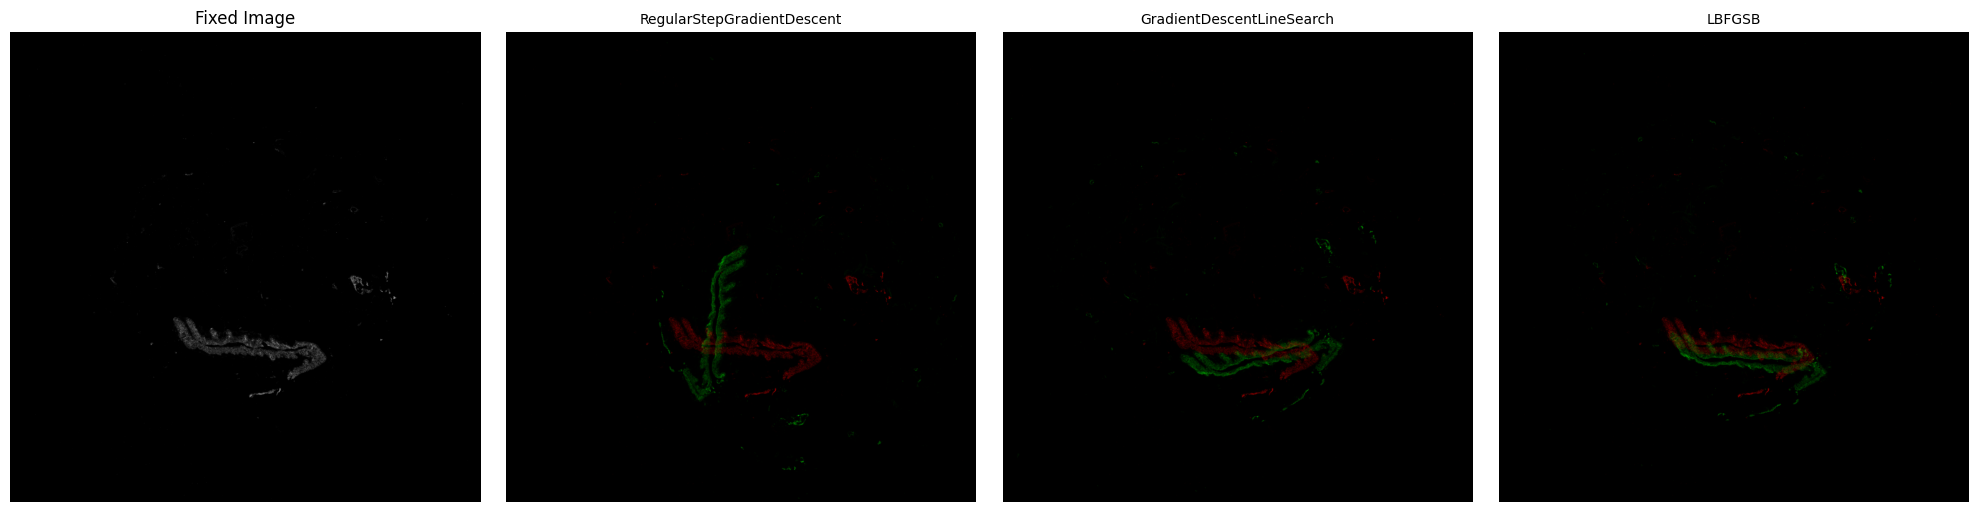

In [4]:
def compare_standard_optimizers_meansquares(fixed, moving):
    fixed = sitk.Cast(fixed, sitk.sitkFloat32)
    moving = sitk.Cast(moving, sitk.sitkFloat32)
    
    # 1. Initialize (Same for all)
    # Using MOMENTS because we know your data is sparse/black-background
    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    # 2. Define the Optimizers to Test
    results = {}
    
    print(f"{'Optimizer':<30} | {'Final Metric':<12} | {'Stop Condition'}")
    print("-" * 75)
    
    # List of configurations
    optimizers = ["RegularStepGradientDescent", "GradientDescentLineSearch", "LBFGSB"]

    for opt_name in optimizers:
        reg = sitk.ImageRegistrationMethod()
        
        # --- METRIC: MEAN SQUARES ---
        # Checks pixel-to-pixel brightness difference (A - B)^2
        reg.SetMetricAsMeanSquares()
        
        # --- SAMPLING: NONE (Use All Pixels) ---
        # Crucial for sparse data + Mean Squares. Random sampling 
        # is too noisy for these sensitive gradient algorithms.
        reg.SetMetricSamplingStrategy(reg.NONE)
        
        # --- OPTIMIZER SETUP ---
        if opt_name == "RegularStepGradientDescent":
            reg.SetOptimizerAsRegularStepGradientDescent(
                learningRate=1.0, 
                minStep=0.001, 
                numberOfIterations=200
            )
        elif opt_name == "GradientDescentLineSearch":
            reg.SetOptimizerAsGradientDescentLineSearch(
                learningRate=1.0, 
                numberOfIterations=200,
                convergenceMinimumValue=1e-6,
                convergenceWindowSize=10
            )
        elif opt_name == "LBFGSB":
            reg.SetOptimizerAsLBFGSB(
                gradientConvergenceTolerance=1e-5,
                numberOfIterations=200,
                maximumNumberOfCorrections=5,
                maximumNumberOfFunctionEvaluations=1000,
                costFunctionConvergenceFactor=1e+7
            )
            
        reg.SetInitialTransform(initial_tx)
        reg.SetInterpolator(sitk.sitkLinear)
        
        try:
            final_tx = reg.Execute(fixed, moving)
            val = reg.GetMetricValue()
            # SimpleITK stores stop condition description differently per optimizer
            stop_cond = reg.GetOptimizerStopConditionDescription()
            
            results[opt_name] = final_tx
            print(f"{opt_name:<30} | {val:.4f}       | {stop_cond[:30]}...")
            
        except Exception as e:
            print(f"{opt_name:<30} | FAILED ({e})")
            results[opt_name] = initial_tx

    # 3. Visualize Comparison
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Fixed Image
    ax = axes[0]
    ax.imshow(sitk.GetArrayFromImage(fixed), cmap='gray')
    ax.set_title("Fixed Image")
    ax.axis('off')
    
    # Helper to overlay
    def show_overlay(ax, tx, title):
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetTransform(tx)
        resampler.SetInterpolator(sitk.sitkLinear)
        moved = resampler.Execute(moving)
        
        f = sitk.GetArrayFromImage(fixed)
        m = sitk.GetArrayFromImage(moved)
        
        # Normalize
        f = f / (f.max() + 1e-6)
        m = m / (m.max() + 1e-6)
        
        ax.imshow(np.dstack((f, m, np.zeros_like(f))))
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    # Plot results
    for i, name in enumerate(optimizers):
        show_overlay(axes[i+1], results[name], name)
    
    plt.tight_layout()
    plt.show()

# Run New Experiment A
compare_standard_optimizers_meansquares(
    fixed_img_full[:,:,CK_CHANNEL_IDX], 
    moving_img_full[:,:,CK_CHANNEL_IDX]
)

### 5.Visualization of Pyramids & Sampling Points

Visualizing Pyramid Levels (Shrink Factors: [1, 4, 16])...


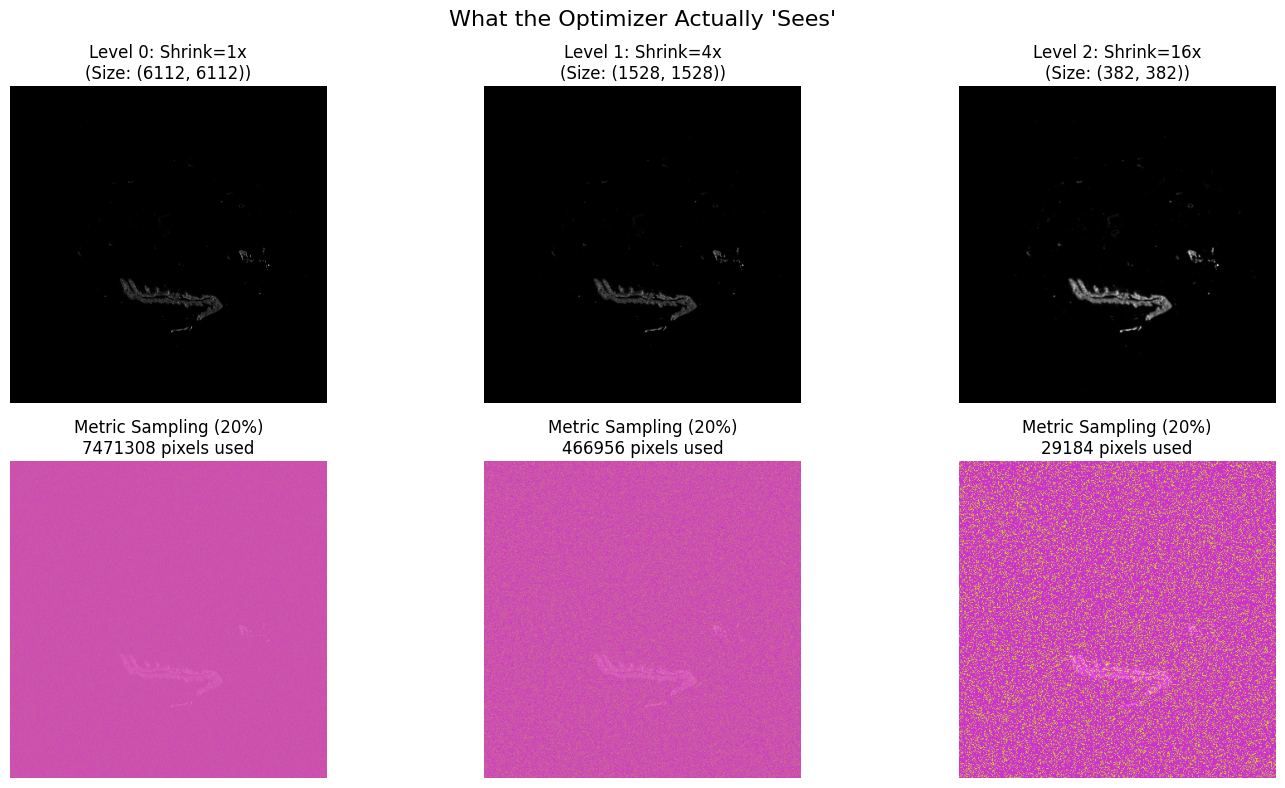

In [5]:
def visualize_sampling_strategies(image, shrink_factors=[1, 4, 16], sampling_percentage=0.05):
    """
    Visualizes:
    1. How the image looks at different pyramid levels (Shrink Factors)
    2. Which pixels are actually used for the metric (Sampling Percentage)
    """
    image = sitk.Cast(image, sitk.sitkFloat32)
    
    # Setup plot
    fig, axes = plt.subplots(2, len(shrink_factors), figsize=(15, 8))
    
    # Row 1: The "Blurred/Shrunk" Image the optimizer sees
    print(f"Visualizing Pyramid Levels (Shrink Factors: {shrink_factors})...")
    
    for i, factor in enumerate(shrink_factors):
        # Downsample using ITK's method
        sigma = 0.5 * factor # Rough sigma rule
        smoothed = sitk.SmoothingRecursiveGaussian(image, sigma)
        shrunk = sitk.Shrink(smoothed, [factor]*2) # Shrink in X and Y
        
        # Display
        ax = axes[0, i]
        ax.imshow(sitk.GetArrayFromImage(shrunk), cmap='gray')
        ax.set_title(f"Level {i}: Shrink={factor}x\n(Size: {shrunk.GetSize()})")
        ax.axis('off')

        # Row 2: The "Sampled Points" (Mask)
        # We create a random mask to show WHAT pixels are chosen
        arr = sitk.GetArrayFromImage(shrunk)
        total_pixels = arr.size
        num_samples = int(total_pixels * sampling_percentage)
        
        # Create an empty black mask
        mask = np.zeros_like(arr)
        
        # Randomly turn on pixels (Indices)
        rng = np.random.default_rng()
        flat_indices = rng.choice(total_pixels, num_samples, replace=False)
        np.put(mask, flat_indices, 1) # Set chosen pixels to 1 (White)
        
        ax2 = axes[1, i]
        ax2.imshow(arr, cmap='gray', alpha=0.5) # Faint background image
        ax2.imshow(mask, cmap='spring', alpha=0.6) # Pink dots = Sampled points
        ax2.set_title(f"Metric Sampling ({int(sampling_percentage*100)}%)\n{num_samples} pixels used")
        ax2.axis('off')

    plt.suptitle("What the Optimizer Actually 'Sees'", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run it on your Fixed Image (CK Channel)

visualize_sampling_strategies(fixed_img_full[:,:,CK_CHANNEL_IDX], sampling_percentage=0.2)

### 6.Experiment C - Metric  (Mattes vs. Mean Squares)

Running Mattes Mutual Information...
Running Mean Squares...


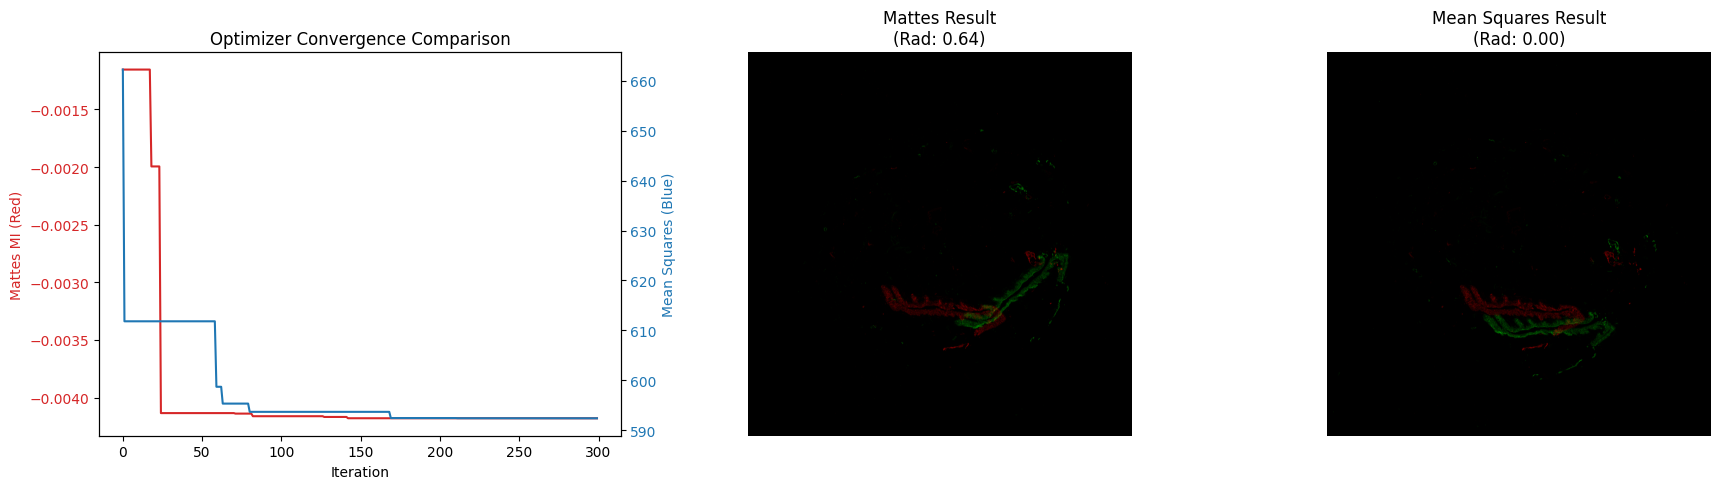

In [6]:
def compare_metrics(fixed, moving):
    fixed = sitk.Cast(fixed, sitk.sitkFloat32)
    moving = sitk.Cast(moving, sitk.sitkFloat32)
    
    # 1. Initialize (The same for both)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.GEOMETRY 
    )
    
    # Define a helper to run registration with a specific metric
    def run_reg(metric_type):
        reg = sitk.ImageRegistrationMethod()
        
        # --- SWITCH METRIC ---
        if metric_type == "Mattes":
            reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        elif metric_type == "MeanSquares":
            reg.SetMetricAsMeanSquares()
            
        # Common Settings
        reg.SetMetricSamplingStrategy(reg.RANDOM)
        reg.SetMetricSamplingPercentage(0.50) # High sampling for accuracy
        reg.SetOptimizerAsOnePlusOneEvolutionary(
            numberOfIterations=300, 
            epsilon=1e-6, 
            initialRadius=5.0, # Increased radius to help it move
            growthFactor=1.1, 
            shrinkFactor=0.9
        )
        reg.SetInitialTransform(initial_tx)
        reg.SetInterpolator(sitk.sitkLinear)
        
        # Record metric values
        values = []
        reg.AddCommand(sitk.sitkIterationEvent, lambda: values.append(reg.GetMetricValue()))
        
        try:
            tx = reg.Execute(fixed, moving)
            return tx, values
        except:
            return initial_tx, []

    # 2. Run Both
    print("Running Mattes Mutual Information...")
    tx_mattes, vals_mattes = run_reg("Mattes")
    
    print("Running Mean Squares...")
    tx_ms, vals_ms = run_reg("MeanSquares")
    
    # 3. Visualize Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Optimization Curves
    # We use two different y-axes because the values are completely different scales
    ax1 = axes[0]
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Mattes MI (Red)", color='tab:red')
    ax1.plot(vals_mattes, color='tab:red', label='Mattes')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("Mean Squares (Blue)", color='tab:blue')
    ax2.plot(vals_ms, color='tab:blue', label='Mean Squares')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    axes[0].set_title("Optimizer Convergence Comparison")

    # Visual Results
    # Resample Mattes
    res_mattes = sitk.Resample(moving, fixed, tx_mattes, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
    # Resample MeanSquares
    res_ms = sitk.Resample(moving, fixed, tx_ms, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
    
    # Helper for overlay
    def get_overlay(f, m):
        f = sitk.GetArrayFromImage(f)
        m = sitk.GetArrayFromImage(m)
        f = f / (f.max()+1e-6)
        m = m / (m.max()+1e-6)
        return np.dstack((f, m, np.zeros_like(f)))

    axes[1].imshow(np.clip(get_overlay(fixed, res_mattes),0,1))
    axes[1].set_title(f"Mattes Result\n(Rad: {tx_mattes.GetParameters()[0]:.2f})")
    
    axes[2].imshow(np.clip(get_overlay(fixed, res_ms),0,1))
    axes[2].set_title(f"Mean Squares Result\n(Rad: {tx_ms.GetParameters()[0]:.2f})")
    
    for ax in axes[1:]: ax.axis('off')
    plt.tight_layout()
    plt.show()

# Run Experiment C
compare_metrics(
    fixed_img_full[:,:,CK_CHANNEL_IDX], 
    moving_img_full[:,:,CK_CHANNEL_IDX]
)

### 7.Rigid vs. Affine

Transform Type       | Final Metric | Iterations
--------------------------------------------------
Rigid (Euler)        | -0.0041       | 300
Affine               | -0.0217       | 300


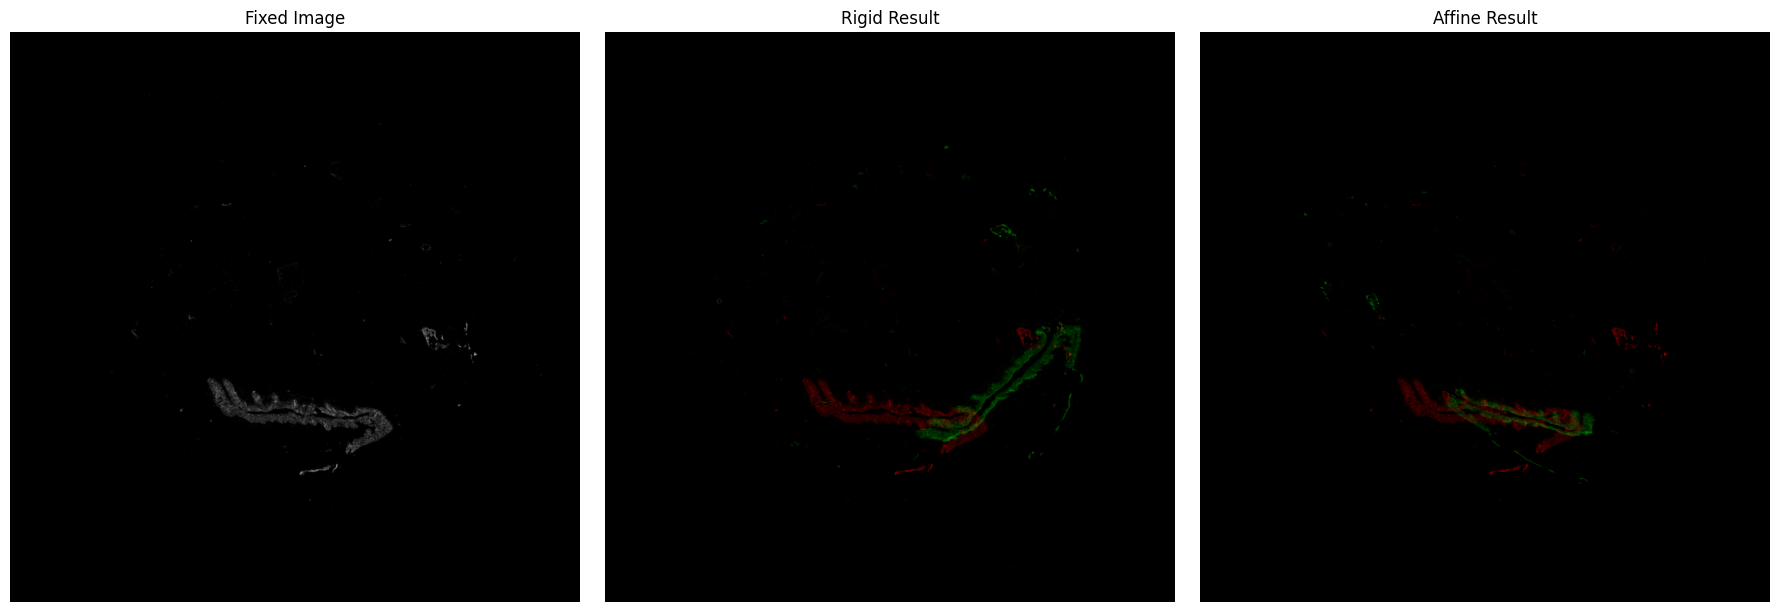

In [7]:
def test_transform_complexity(fixed, moving):
    fixed = sitk.Cast(fixed, sitk.sitkFloat32)
    moving = sitk.Cast(moving, sitk.sitkFloat32)
    
    # 1. Define the Two Transforms to Test
    # We initialize both using GEOMETRY to keep it fair
    transforms = {
        "Rigid (Euler)": sitk.CenteredTransformInitializer(
            fixed, moving, 
            sitk.Euler2DTransform(), 
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        ),
        "Affine": sitk.CenteredTransformInitializer(
            fixed, moving, 
            sitk.AffineTransform(2), # 2 is the dimension 
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
    }
    
    results = {}
    
    print(f"{'Transform Type':<20} | {'Final Metric':<12} | {'Iterations':<5}")
    print("-" * 50)

    # 2. Run Both
    for name, initial_tx in transforms.items():
        reg = sitk.ImageRegistrationMethod()
        
        # Standard "Safe" Settings
        reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        reg.SetMetricSamplingStrategy(reg.RANDOM)
        reg.SetMetricSamplingPercentage(0.40) # 40% Sampling
        
        reg.SetOptimizerAsOnePlusOneEvolutionary(
            numberOfIterations=300, 
            epsilon=1e-6, 
            initialRadius=1.0 # Smaller radius usually better for Affine
        )
        
        # Conservative Pyramids to keep tissue visible
        reg.SetShrinkFactorsPerLevel([4, 2, 1])
        reg.SetSmoothingSigmasPerLevel([2, 1, 0])
        
        reg.SetInitialTransform(initial_tx)
        
        try:
            # Run
            final_tx = reg.Execute(fixed, moving)
            val = reg.GetMetricValue()
            iter_count = reg.GetOptimizerIteration()
            results[name] = final_tx
            print(f"{name:<20} | {val:.4f}       | {iter_count}")
        except Exception as e:
            print(f"{name:<20} | FAILED ({e})")
            results[name] = initial_tx

    # 3. Visualize Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Fixed Image
    ax = axes[0]
    ax.imshow(sitk.GetArrayFromImage(fixed), cmap='gray')
    ax.set_title("Fixed Image")
    ax.axis('off')
    
    # Helper to overlay
    def show_overlay(ax, tx, title):
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetTransform(tx)
        resampler.SetInterpolator(sitk.sitkLinear)
        moved = resampler.Execute(moving)
        
        f = sitk.GetArrayFromImage(fixed)
        m = sitk.GetArrayFromImage(moved)
        
        # Normalize
        f = f / (f.max() + 1e-6)
        m = m / (m.max() + 1e-6)
        
        ax.imshow(np.dstack((f, m, np.zeros_like(f))))
        ax.set_title(title)
        ax.axis('off')

    show_overlay(axes[1], results["Rigid (Euler)"], "Rigid Result")
    show_overlay(axes[2], results["Affine"], "Affine Result")
    
    plt.tight_layout()
    plt.show()

# Run Experiment E
test_transform_complexity(
    fixed_img_full[:,:,CK_CHANNEL_IDX], 
    moving_img_full[:,:,CK_CHANNEL_IDX]
)

Transform Type       | Final Metric | Iterations
--------------------------------------------------
Rigid (Euler)        | -0.0083       | 300
Affine               | -0.0157       | 300


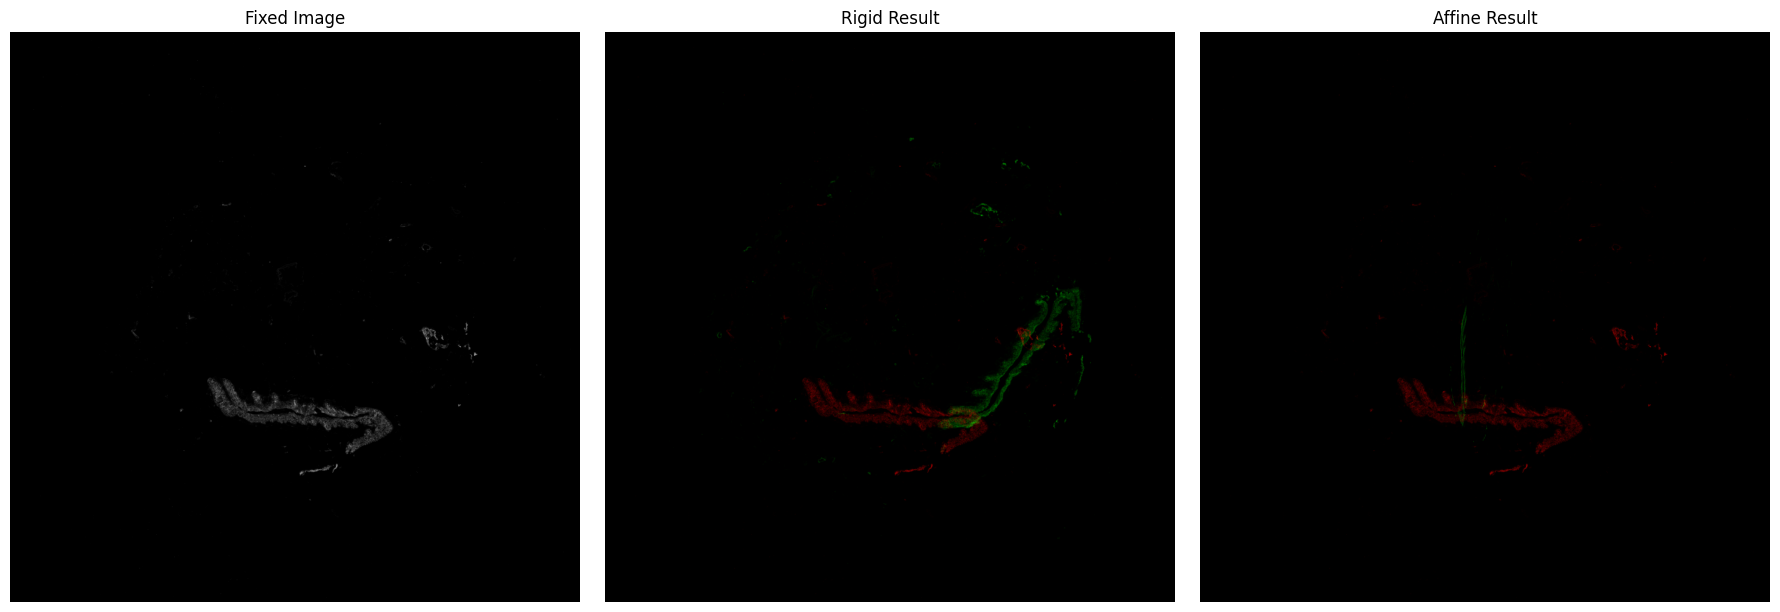

In [8]:
def test_transform_complexity_no_pyramids(fixed, moving):
    fixed = sitk.Cast(fixed, sitk.sitkFloat32)
    moving = sitk.Cast(moving, sitk.sitkFloat32)
    
    # 1. Define Transforms
    transforms = {
        "Rigid (Euler)": sitk.CenteredTransformInitializer(
            fixed, moving, 
            sitk.Euler2DTransform(), 
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        ),
        "Affine": sitk.CenteredTransformInitializer(
            fixed, moving, 
            sitk.AffineTransform(2), 
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
    }
    
    results = {}
    
    print(f"{'Transform Type':<20} | {'Final Metric':<12} | {'Iterations':<5}")
    print("-" * 50)

    # 2. Run Both
    for name, initial_tx in transforms.items():
        reg = sitk.ImageRegistrationMethod()
        
        # --- ORIGINAL SETTINGS ---
        reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        
        # Using High Sampling (50%) to rule out 'bad luck'
        # Change to 0.20 if you want to match the script's randomness exactly
        reg.SetMetricSamplingStrategy(reg.RANDOM)
        reg.SetMetricSamplingPercentage(0.50)
        
        reg.SetOptimizerAsOnePlusOneEvolutionary(
            numberOfIterations=300, 
            epsilon=1e-6, 
            initialRadius=1.5,
            growthFactor=1.1, 
            shrinkFactor=0.9
        )
        
        # --- STRICT SINGLE LEVEL (Matches your script) ---
        reg.SetShrinkFactorsPerLevel([16]) 
        reg.SetSmoothingSigmasPerLevel([2])
        reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
        
        reg.SetInitialTransform(initial_tx)
        
        try:
            final_tx = reg.Execute(fixed, moving)
            val = reg.GetMetricValue()
            iter_count = reg.GetOptimizerIteration()
            results[name] = final_tx
            print(f"{name:<20} | {val:.4f}       | {iter_count}")
        except Exception as e:
            print(f"{name:<20} | FAILED ({e})")
            results[name] = initial_tx

    # 3. Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Fixed
    ax = axes[0]
    ax.imshow(sitk.GetArrayFromImage(fixed), cmap='gray')
    ax.set_title("Fixed Image")
    ax.axis('off')
    
    # Helper
    def show_overlay(ax, tx, title):
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetTransform(tx)
        resampler.SetInterpolator(sitk.sitkLinear)
        moved = resampler.Execute(moving)
        
        f = sitk.GetArrayFromImage(fixed)
        m = sitk.GetArrayFromImage(moved)
        
        # Normalize
        f = f / (f.max() + 1e-6)
        m = m / (m.max() + 1e-6)
        
        ax.imshow(np.dstack((f, m, np.zeros_like(f))))
        ax.set_title(title)
        ax.axis('off')

    show_overlay(axes[1], results["Rigid (Euler)"], "Rigid Result")
    show_overlay(axes[2], results["Affine"], "Affine Result")
    
    plt.tight_layout()
    plt.show()

# Run Experiment
test_transform_complexity_no_pyramids(
    fixed_img_full[:,:,CK_CHANNEL_IDX], 
    moving_img_full[:,:,CK_CHANNEL_IDX]
)

### Exhaustive

Running Exhaustive Search (Scanning X/Y shifts)...

--- RESULTS ---
Best Metric Value: -0.011988537796034529
Best Rotation:     0.00 degrees
Best Shift X:      221.64 pixels
Best Shift Y:      186.29 pixels


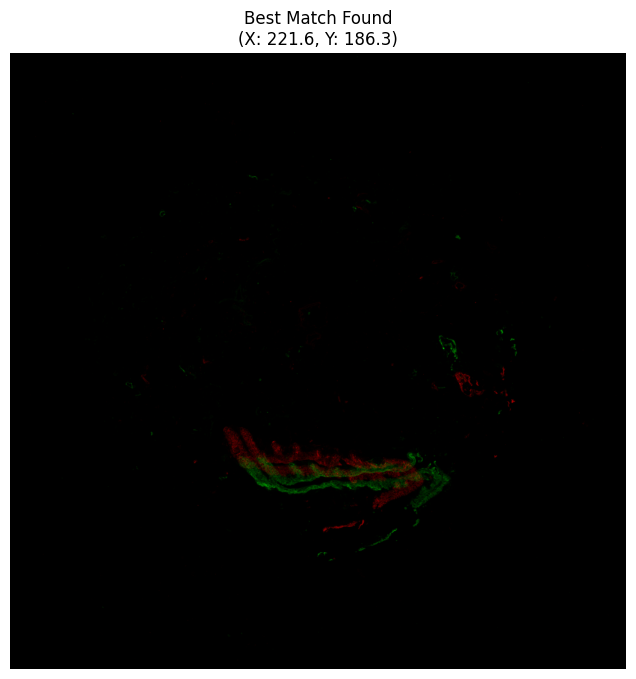

<SimpleITK.SimpleITK.Euler2DTransform; proxy of <Swig Object of type 'itk::simple::Euler2DTransform *' at 0x7f655456c6c0> >

In [5]:
def scan_landscape_with_results(fixed, moving):
    fixed = sitk.Cast(fixed, sitk.sitkFloat32)
    moving = sitk.Cast(moving, sitk.sitkFloat32)

    # 1. Setup
    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving,
        sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )

    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.20)

    # 2. EXHAUSTIVE SETUP
    # [Rotation Steps, X Steps, Y Steps]
    # This scans:
    #   Rotation: 0 steps (Fixed)
    #   X: ±20 steps * 2.0mm = ±40mm range
    #   Y: ±20 steps * 2.0mm = ±40mm range
    reg.SetOptimizerAsExhaustive(
        numberOfSteps=[0, 20, 20],
        stepLength=2.0
    )

    reg.SetInitialTransform(initial_tx)
    reg.SetInterpolator(sitk.sitkLinear)

    # 3. ADD TRACKING (The missing part)
    # We need to manually watch the optimizer to see "Who is winning?"
    # SimpleITK's Exhaustive optimizer automatically sets the transform to the best
    # position at the end, but let's print it to be sure.

    print("Running Exhaustive Search (Scanning X/Y shifts)...")

    try:
        final_tx = reg.Execute(fixed, moving)

        # 4. EXTRACT RESULTS
        # The 'final_tx' is already updated to the best location found.
        best_val = reg.GetMetricValue()
        params = final_tx.GetParameters()

        # params[0] = Rotation (Radians)
        # params[1] = Shift X
        # params[2] = Shift Y
        print(f"\n--- RESULTS ---")
        print(f"Best Metric Value: {best_val}")
        print(f"Best Rotation:     {np.degrees(params[0]):.2f} degrees")
        print(f"Best Shift X:      {params[1]:.2f} pixels")
        print(f"Best Shift Y:      {params[2]:.2f} pixels")

        # 5. VISUALIZE THE WINNER
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetTransform(final_tx)
        out = resampler.Execute(moving)

        f = sitk.GetArrayFromImage(fixed)
        m = sitk.GetArrayFromImage(out)
        
        # Normalize for display
        f = f / (f.max() + 1e-6)
        m = m / (m.max() + 1e-6)

        plt.figure(figsize=(8,8))
        plt.imshow(np.dstack((f, m, np.zeros_like(f))))
        plt.title(f"Best Match Found\n(X: {params[1]:.1f}, Y: {params[2]:.1f})")
        plt.axis('off')
        plt.show()

        return final_tx

    except Exception as e:
        print(f"Failed: {e}")
        return initial_tx

# Run it
scan_landscape_with_results(
    fixed_img_full[:,:,CK_CHANNEL_IDX],
    moving_img_full[:,:,CK_CHANNEL_IDX]
)

### Standard Optimizers vs. Mean Squares

Optimizer                      | Metric     | Stop Condition
--------------------------------------------------------------------------------
RegularStepGradientDescent     | 665.9192     | RegularStepGradientDescentOptimizerv4: S...
LBFGSB                         | 617.6726     | LBFGSBOptimizerv4: Function tolerance re...
Amoeba                         | 615.8863     | AmoebaOptimizerv4: Both parameters conve...


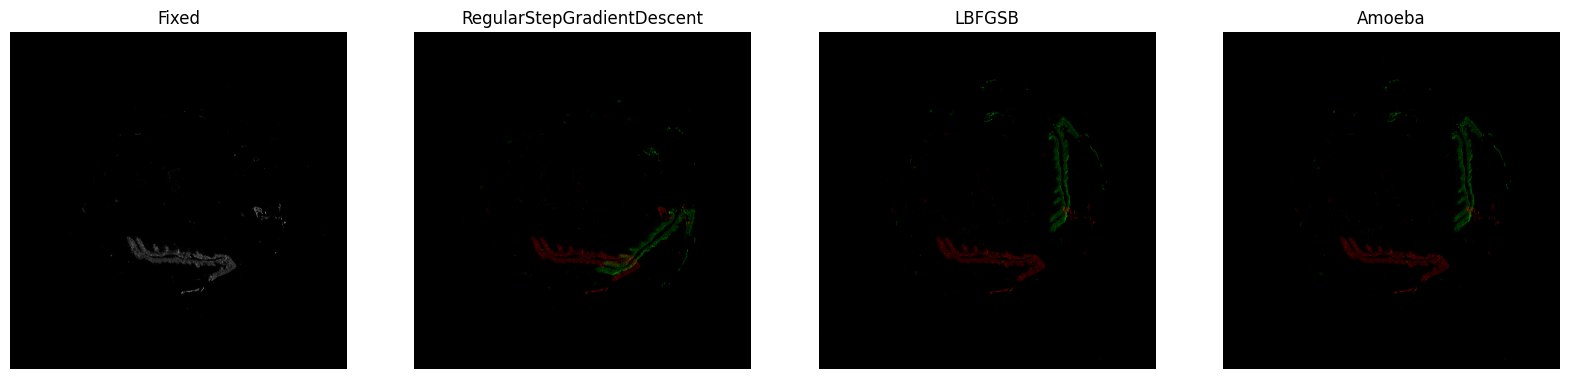

In [4]:
def compare_valid_optimizers(fixed, moving):
    fixed = sitk.Cast(fixed, sitk.sitkFloat32)
    moving = sitk.Cast(moving, sitk.sitkFloat32)
    
    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    
    # The valid list for SimpleITK
    optimizers = ["RegularStepGradientDescent", "LBFGSB", "Amoeba"]
    results = {}
    
    print(f"{'Optimizer':<30} | {'Metric':<10} | {'Stop Condition'}")
    print("-" * 80)
    
    for name in optimizers:
        reg = sitk.ImageRegistrationMethod()
        
        # Use MeanSquares as requested
        reg.SetMetricAsMeanSquares()
        reg.SetMetricSamplingStrategy(reg.NONE) # Mean Squares needs all pixels usually
        
        if name == "RegularStepGradientDescent":
            reg.SetOptimizerAsRegularStepGradientDescent(
                learningRate=1.0, minStep=0.001, numberOfIterations=200
            )
        elif name == "LBFGSB":
            reg.SetOptimizerAsLBFGSB(
                gradientConvergenceTolerance=1e-5, numberOfIterations=200,
                maximumNumberOfCorrections=5, maximumNumberOfFunctionEvaluations=1000,
                costFunctionConvergenceFactor=1e+7
            )
        elif name == "Amoeba":
            # Nelder-Mead (Amoeba) is the closest valid alternative to SA
            # It crawls around the solution space without needing gradients
            reg.SetOptimizerAsAmoeba(
                simplexDelta=2.0, # Size of the initial "creature"
                numberOfIterations=200
            )

        reg.SetInitialTransform(initial_tx)
        reg.SetInterpolator(sitk.sitkLinear)
        
        try:
            out_tx = reg.Execute(fixed, moving)
            val = reg.GetMetricValue()
            stop = reg.GetOptimizerStopConditionDescription()
            results[name] = out_tx
            print(f"{name:<30} | {val:.4f}     | {stop[:40]}...")
        except Exception as e:
            print(f"{name:<30} | FAILED ({e})")
            results[name] = initial_tx

    # Visual Comparison (Same as before)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(sitk.GetArrayFromImage(fixed), cmap='gray')
    axes[0].set_title("Fixed")
    axes[0].axis('off')
    
    for i, name in enumerate(optimizers):
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetTransform(results[name])
        moved = resampler.Execute(moving)
        
        f = sitk.GetArrayFromImage(fixed)
        m = sitk.GetArrayFromImage(moved)
        # Normalize for display
        f = f/f.max(); m = m/m.max()
        
        axes[i+1].imshow(np.dstack((f, m, np.zeros_like(f))))
        axes[i+1].set_title(name)
        axes[i+1].axis('off')
    plt.show()

# Run
compare_valid_optimizers(fixed_img_full[:,:,CK_CHANNEL_IDX], moving_img_full[:,:,CK_CHANNEL_IDX])